# Initialiazation Packages

In [1]:
using LinearAlgebra
using PyPlot
using PyCall
using LaTeXStrings
using QuantumToolbox
using DelimitedFiles, NLsolve
using Random, Distributions, Dates, Polynomials, StatsBase 
using JLD

In [3]:
#using Pkg
#Pkg.activate("..")

include("../src/Classical_2KPOs_functions.jl")
using .Classical_KPOs

## Eigenstates $PR_{coh}$ and classical energies

In [4]:
#Definitions
ps = [0.01, 1., 3., 5.]
N_p = length(ps)
θ1s = fill(NaN, N_p, 30)
s_λs = fill("", N_p, 30)
Δ1, K1, ξ11, ξ21, Δ2, K2, ξ12, ξ22 = 0., 1., 0., 5., 0., 1., 0., 5. # For γ
#Δ1, K1, ξ11, Δ2, K2, ξ12, γ = 0., 1., 0., 0., 1., 0., 1. # For ξ2
#K1, ξ11, ξ21, K2, ξ12, ξ22, γ = 1., 0., 5., 1., 0., 5., 1. # For Δ

(0.0, 1.0, 0.0, 5.0, 0.0, 1.0, 0.0, 5.0)

In [6]:
for j in 1:N_p
    parameters = Δ1, K1, ξ11, ξ21, Δ2, K2, ξ12, ξ22, ps[j] 
    
    roots, cE, λs, s_λ = crit_energies2(parameters,100,7);
    R = length(roots)
    θ1= zeros(R)
    #println(j)
    
    for i in 1:R
        θ1[i] = atan(roots[i][3], roots[i][1])
    end
    #sort(q1, by=real)'
    #sort(q11, by=real)' 
    sorted_indices = sortperm(θ1)
    roots, s_λ = roots[sorted_indices], s_λ[sorted_indices]
    
    for i in 1:R
        #println(j,i)
        θ1s[j, i] = atan(roots[i][3], roots[i][1])
        s_λs[j, i] = s_λ[i]         
    end 
end

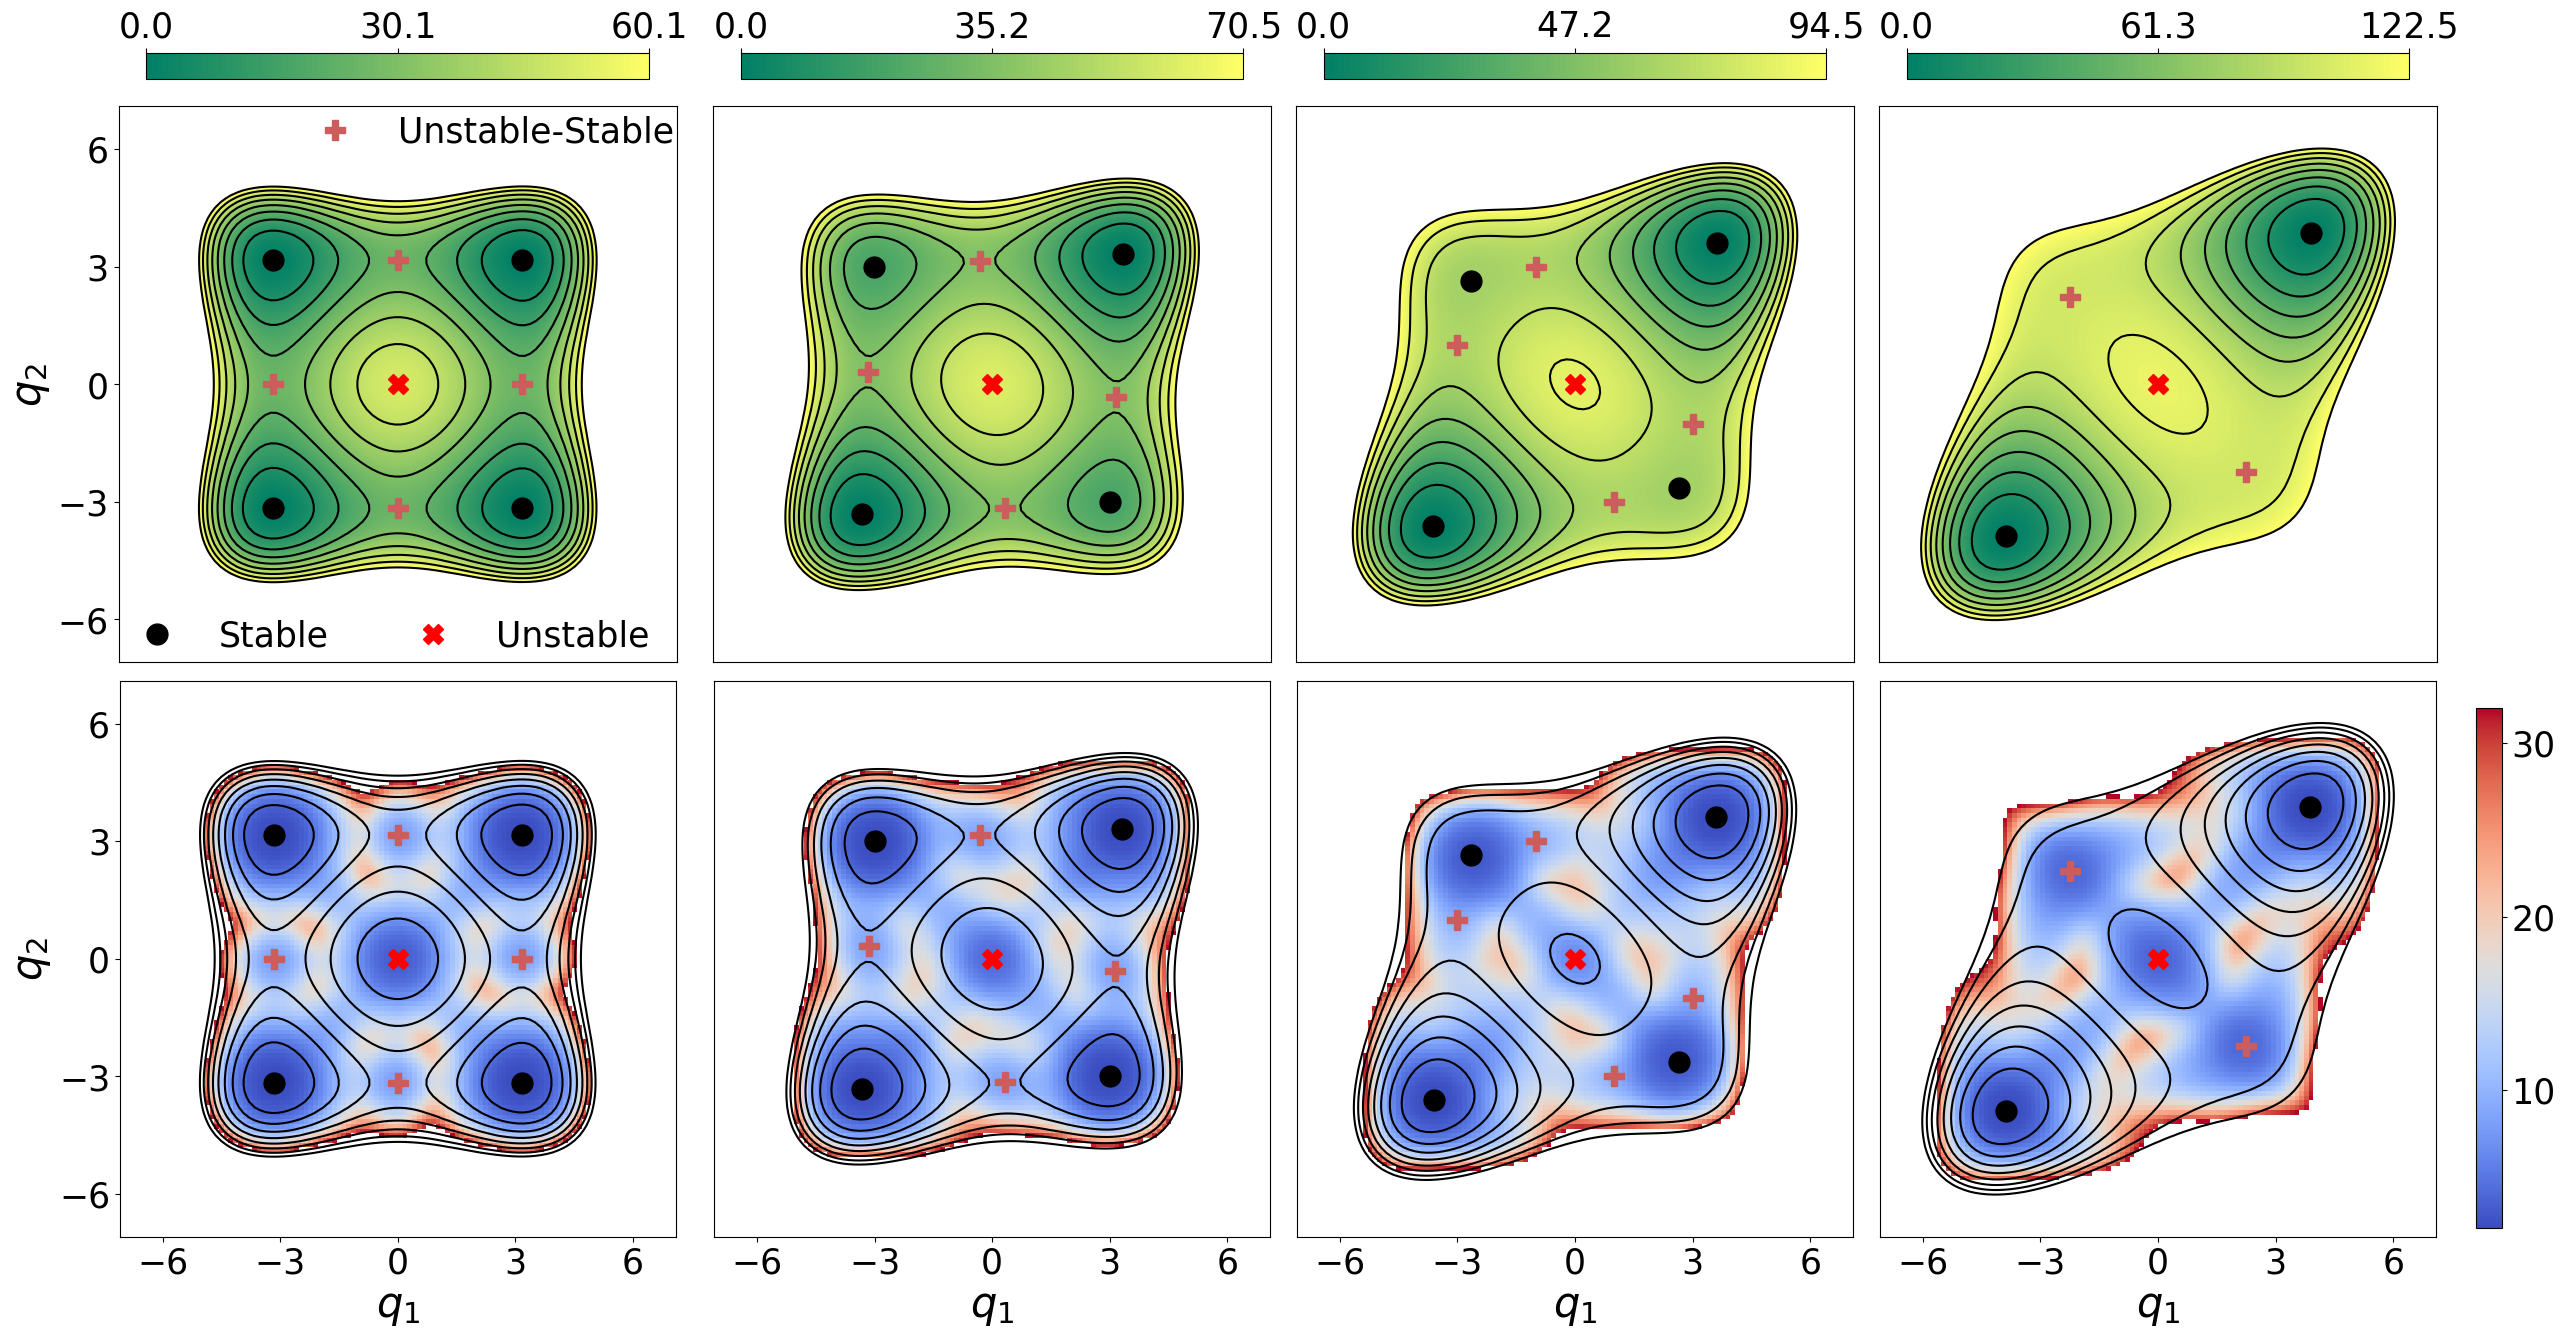

In [8]:
fig = figure(figsize=(26, 13),layout="constrained" )
font_s = 25
gs = fig.add_gridspec(2,5, width_ratios=[1, 1, 1, 1, 0.25])
element(i,j) = get(gs, (i,j)) # starts at 0 to N-1
slice(i,j) = pycall(pybuiltin("slice"), PyObject, i,j)
cmap_ = "summer"
xx= x_lim = 7.09090909090909
for j in 1:N_p
    parameters = Δ1, K1, ξ11, ξ21, Δ2, K2, ξ12, ξ22, ps[j] 
    roots_, E_cl, λs, s_λ = crit_energies2(parameters,200,7);
    ax = fig.add_subplot(element(0,j-1))
    plots_rs = []
    for i in 1:length(roots_)
        if s_λ[i] =="Saddle"
            plot_r, = plot(roots_[i][1], roots_[i][3], linestyle="None",marker="X", markersize=15, color = "red", label="Unstable")
        elseif s_λ[i] =="Saddle-focus"
            plot_r, = plot(roots_[i][1], roots_[i][3], linestyle="None", marker="P", markersize=15, color = "indianred", label="Unstable-Stable")
        else #center
            plot_r, = plot(roots_[i][1], roots_[i][3], linestyle="None", marker="o", markersize=15, color = "black", label="Stable")
        end
        push!(plots_rs, plot_r)
    end

    x = range(-xx, xx, length=100);
    y = range(-xx, xx, length=100);

    #Equivalent of meshgrid
    coordinates_x = repeat(x', length(x), 1);
    coordinates_y = repeat(y, 1, length(y));
    
    q1, p1, q2, p2 = coordinates_x,0, coordinates_y,0;#q1,q2 
    E_Contours = H_class([q1, p1, q2, p2],parameters) .- E_cl[1];

    Emin, Emax = 0, -E_cl[1]+10 #E_cl[1],10.
    CS = contourf(coordinates_x, coordinates_y, E_Contours, range(Emin, Emax, length = 101), cmap=cmap_)#, vmax = -E_cl[1]+10);
    #CS = contourf(coordinates_x, coordinates_y, E_Contours, cmap=cmap_, vmax = 0)
    #contour(coordinates_x, coordinates_y, E_Contours, range(Emin, -1, length = 8), colors="black"); # Only draw contour line for E = 0
    contour(coordinates_x, coordinates_y, E_Contours, range(Emin,-E_cl[1]+10, length = 9), colors="black"); # Only draw contour line for E = 0
    #custom_ticks = round.([Emin+5, (Emin+Emax)/2,Emax - 5 ],digits=1)
    #xlabel(L"q_1",fontsize=20)
    #ylabel(L"q_2",fontsize=20) #q1,q2
    custom_ticks = round.([Emin, (Emin+(-E_cl[1]+10))/2, -E_cl[1]+10],digits=1)
    cbar = colorbar(CS,location="top", ticks=custom_ticks, shrink=0.9)
    cbar.ax.tick_params(axis="x", labelsize=font_s)
    cbar.ax.set_xlim(0, -E_cl[1]+10)

     if j ==1
        legend1 = legend(frameon=false, handles=plots_rs[[5]], loc="upper right",bbox_to_anchor=(1.05, 1.04), fontsize=font_s,scatterpoints=1)
        ax.add_artist(legend1)
        legend2 = legend(frameon=false, handles=plots_rs[[1,9]], loc="lower left",bbox_to_anchor=(-.05, -.04), ncol=2, fontsize=font_s)
    end


    #cbar = colorbar(CS,location="top", ticks=custom_ticks, shrink=0.9)
    #cbar.ax.tick_params(axis="x", labelsize=15)
    if j == 1
        yticks([-6,-3,0,3,6],fontsize=font_s)
        ylabel(L"q_{2}", fontsize=font_s+5)
    else
        yticks([])
    end
    xticks([])
    #xlim(-6,6)
    #ax.text(.01, 0.95, L"γ = %$(ps[j])", color="red",transform=ax.transAxes, fontsize=20, verticalalignment="top")


    ax = fig.add_subplot(element(1,j-1))
    N = 100;
    N_Q = 100
    IPR = zeros(N_Q,N_Q)
    for job in 1:10
        IPR += load("C:/Users/edson/Desktop/Research/Kerr_system/Coupled_kerr/codes_Chemistry/data/PR_coh/IPR_p_$(parameters)_N_$(N)_N_Q_$(N_Q)_job_$(job).jld")["IPR_coh"];
    end
    PR = 1 ./ IPR
    q1vals, p1vals, q2vals, p2vals = range(-x_lim,x_lim, length=N_Q),range(-x_lim,x_lim, length=N_Q),range(-x_lim,x_lim, length=N_Q),range(-x_lim,x_lim, length=N_Q)
    PR_aux = (ones(118,118)*100)
    PR_aux[10:109,10:109] = PR
    cmap = matplotlib.cm.get_cmap("coolwarm").copy()
    cmap.set_over("white")
    im = imshow(PR_aux,origin="lower",cmap=cmap, extent=(-7.09090909090909,7.09090909090909, -7.09090909090909,7.09090909090909), vmax = 32)
    
    if j == 1
        ylabel(L"q_2", fontsize=font_s+5)
        yticks([-6,-3,0,3,6],fontsize=font_s)
    else
        yticks([])
    end
   
    for i in 1:length(roots_)
        if s_λ[i] =="Saddle"
            plot_r, = plot(roots_[i][1], roots_[i][3], linestyle="None",marker="X", markersize=15, color = "red", label="Unstable")
        elseif s_λ[i] =="Saddle-focus"
            plot_r, = plot(roots_[i][1], roots_[i][3], linestyle="None", marker="P", markersize=15, color = "indianred", label="Unstable-Stable")
        else #center
            plot_r, = plot(roots_[i][1], roots_[i][3], linestyle="None", marker="o", markersize=15, color = "black", label="Stable")
        end
        push!(plots_rs, plot_r)
    end
    contour(coordinates_x, coordinates_y, E_Contours, range(Emin,-E_cl[1]+10, length = 9), colors="black"); # Only draw contour line for E = 0
    
    xlabel(L"q_1", fontsize=font_s+5)
    xticks([-6,-3,0,3,6],fontsize=font_s)
    xlim(-7.09090909090909,7.09090909090909)
    
    #cbar = colorbar(im,label="PR")

    if j == N_p
        #[x, y, width, height]
        cax_ = fig.add_axes([0.95, 0.06, 0.01, 0.4]) 
        custom_ticks = [0.0, 10.,20., 30.]
        cbar = plt.colorbar(im, ticks=custom_ticks,cax = cax_)
        cbar.ax.tick_params(labelsize=font_s)
    end

    #ax.text(.5, 1.05, L"E", transform=ax.transAxes, fontsize=20)
end

#savefig("C:/Users/edson/Desktop/Research/Kerr_system/Coupled_kerr/codes_Chemistry/Classical_Kerr/Figures/Fixed_points_stability_equivalent_γ_3.png")
#savefig("C:/Users/edson/Desktop/ixed_points_stability_equivalent_γ_3.png")
#end
#plot_γ()

